# CNN-LSTM Seperate Models

Importing batch data

In [377]:
from pymongo import MongoClient
import pandas as pd
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Dropout , Input , TimeDistributed , Dense , LSTM

In [378]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [379]:
connection = MongoClient('localhost' , 27017)
db = connection['mydb']
collection = db['1000_Batch_Data']

In [380]:
#Extracting the data

cursor = collection.find({}) 
batch_df = pd.DataFrame(list(cursor))

In [381]:
batch_df.head()

,_id,landmarks,label
0,672af22fe02a1652aab644af,"[{'face': [[0.528167724609375, 0.2578373367231...",book
1,672af22fe02a1652aab644b0,"[{'face': [[0.242395827902416, 0.2020864317403...",book
2,672af22fe02a1652aab644b1,"[{'face': [[0.4664744738874764, 0.219961448490...",book
3,672af22fe02a1652aab644b2,"[{'face': [[0.479362738886966, 0.2433891842543...",book
4,672af22fe02a1652aab644b3,"[{'face': [[0.492517174267378, 0.0870498852922...",book


In [382]:
len(batch_df['landmarks'][0])

30

In [383]:

#converting the string values into numeric values

label_encoder = LabelEncoder()
batch_df['label_encoded'] = label_encoder.fit_transform(batch_df['label'])


In [384]:
batch_df

,_id,landmarks,label,label_encoded
0,672af22fe02a1652aab644af,"[{'face': [[0.528167724609375, 0.2578373367231...",book,11
1,672af22fe02a1652aab644b0,"[{'face': [[0.242395827902416, 0.2020864317403...",book,11
2,672af22fe02a1652aab644b1,"[{'face': [[0.4664744738874764, 0.219961448490...",book,11
3,672af22fe02a1652aab644b2,"[{'face': [[0.479362738886966, 0.2433891842543...",book,11
4,672af22fe02a1652aab644b3,"[{'face': [[0.492517174267378, 0.0870498852922...",book,11
...,...,...,...,...
995,672af22fe02a1652aab64892,"[{'face': [[0.41673927693753626, 0.20555076170...",tell,85
996,672af22fe02a1652aab64893,"[{'face': [[0.5213522366115024, 0.215353012084...",tell,85
997,672af22fe02a1652aab64894,"[{'face': [[0.609763869822351, 0.2657764752705...",tell,85
998,672af22fe02a1652aab64895,"[{'face': [[0.45382191153133605, 0.19372511709...",tell,85


In [385]:
# # Makin sure that each landmark for video is a dictionary , i.e removig outer list

# batch_df['landmarks'] = batch_df['landmarks'].apply(lambda x : x[0] if isinstance(x,list) else x)

In [386]:
# batch_df.head()

In [387]:
len(batch_df['landmarks'][0])

30

Reshaping the Landmarks to align all the landmarks

In [388]:
def reshape_landmarks(record):

 iterations = len(record)
 
 concatenated_one_video = []

 for count in range(iterations):
 
    face_lands = np.array(record[count]['face'])
    left_hand_lands = np.array(record[count]['left_hand'])
    right_hand_lands = np.array(record[count]['right_hand'])

    #Concatinating all the landmarks to the shape (510 , 3)

    all_landmarks = np.vstack([face_lands , left_hand_lands , right_hand_lands]) # concatenated landmarks for 1 frame of the video

    concatenated_one_video.append(all_landmarks)
 
 return np.array(concatenated_one_video)

In [389]:
r1 = reshape_landmarks(batch_df['landmarks'][0])

In [390]:
r2 = reshape_landmarks(batch_df['landmarks'][1])

In [391]:
r1.shape

(30, 510, 3)

In [392]:
r2.shape

(30, 510, 3)

In [393]:
batch_df['concatenated_landmarks'] = batch_df['landmarks'].progress_apply(reshape_landmarks)

100%|██████████| 1000/1000 [00:08<00:00, 124.07it/s]


In [394]:
batch_df.head()

,_id,landmarks,label,label_encoded,concatenated_landmarks
0,672af22fe02a1652aab644af,"[{'face': [[0.528167724609375, 0.2578373367231...",book,11,"[[[0.528167724609375, 0.25783733672313774, -0...."
1,672af22fe02a1652aab644b0,"[{'face': [[0.242395827902416, 0.2020864317403...",book,11,"[[[0.242395827902416, 0.20208643174030372, -0...."
2,672af22fe02a1652aab644b1,"[{'face': [[0.4664744738874764, 0.219961448490...",book,11,"[[[0.4664744738874764, 0.21996144849046956, -0..."
3,672af22fe02a1652aab644b2,"[{'face': [[0.479362738886966, 0.2433891842543...",book,11,"[[[0.479362738886966, 0.2433891842543816, -0.0..."
4,672af22fe02a1652aab644b3,"[{'face': [[0.492517174267378, 0.0870498852922...",book,11,"[[[0.492517174267378, 0.08704988529227371, -0...."


In [395]:
((batch_df['concatenated_landmarks'][5].reshape(30 , 510 , 3 ,1))[1]).shape

(510, 3, 1)

In [396]:
batch_df['concatenated_landmarks'][5].shape

(30, 510, 3)

In [397]:
batch_df['concatenated_landmarks'].progress_apply(lambda row : (row).shape )

100%|██████████| 1000/1000 [00:00<00:00, 249705.54it/s]


0      (30, 510, 3)
1      (30, 510, 3)
2      (30, 510, 3)
3      (30, 510, 3)
4      (30, 510, 3)
           ...     
995    (30, 510, 3)
996    (30, 510, 3)
997    (30, 510, 3)
998    (30, 510, 3)
999    (30, 510, 3)
Name: concatenated_landmarks, Length: 1000, dtype: object

In [398]:
#Resphaing the data to apply conv2D filter on the input data
batch_df['concatenated_landmarks'] = batch_df['concatenated_landmarks'].progress_apply(lambda row : row.reshape(30 , 510 , 3 , 1) )

100%|██████████| 1000/1000 [00:00<00:00, 249794.77it/s]


In [399]:
batch_df['concatenated_landmarks'][88].shape

(30, 510, 3, 1)

In [400]:
one_hot_encoded_labels = tf.keras.utils.to_categorical(batch_df['label_encoded'])

In [401]:
type(one_hot_encoded_labels)

numpy.ndarray

In [402]:
one_hot_encoded_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Splitting the Data into Train and Test set

In [403]:
X = batch_df['concatenated_landmarks']
Y = one_hot_encoded_labels

In [404]:
# using 75 - 25 train - test split

X_train , X_test , Y_train , Y_test = train_test_split(X , Y , test_size= 0.25 , shuffle= True , random_state= 42 )

In [405]:
X_train = np.array(X_train.tolist())

In [406]:
X_test = np.array(X_test.tolist())

In [407]:
type(X_train)

numpy.ndarray

In [408]:
X_train.shape

(750, 30, 510, 3, 1)

In [409]:
X_train[0].shape

(30, 510, 3, 1)

In [410]:
Y.shape

(1000, 99)

In [411]:
Y.shape[1]

99

## Creating Convolutional Neural Network to Extract Feature Maps for each frames

Reshaping videos landmark data
- face - 468 landmarks
- left-hand - 21 landmarks
- right-hand - 21 landmarks
- to Pass t conv2D layer -> arranging the landmarks for each frame in the shape = (468 + 21 + 21 , 3) = (510 , 3)

In [412]:
def CNN_model(input_shape = (30 , 510 , 3 , 1)):

 """
 Creating a CNN model for feature extraction from individual frames
 Input shape : (timestep , landmarks , coordinates , channels)
 """
 #Defining a Sequential Model
 model = Sequential() 

 #Defining the Model architecture

 #CNN Layer 1
 model.add(TimeDistributed(Conv2D(filters= 16 , kernel_size= (3,3) , padding='same' , activation='relu' , input_shape = input_shape )))
 # model.add(TimeDistributed(MaxPooling2D((1,2))))
 model.add(TimeDistributed(Dropout(0.25)))

 #CNN Layer 2
 model.add(TimeDistributed(Conv2D(filters= 32 , kernel_size= (3,3) , padding='same' , activation='relu')))
 # model.add(TimeDistributed(MaxPooling2D((1,2))))
 model.add(TimeDistributed(Dropout(0.25)))

  #CNN Layer 3
 model.add(TimeDistributed(Conv2D(filters= 64 , kernel_size= (3,3) , padding='same' , activation='relu')))
 # model.add(TimeDistributed(MaxPooling2D((1,2))))
 model.add(TimeDistributed(Dropout(0.25)))

  #CNN Layer 4
 model.add(TimeDistributed(Conv2D(filters= 64 , kernel_size= (3,3) , padding='same' , activation='relu')))
 # model.add(TimeDistributed(MaxPooling2D((1,2))))
 # model.add(TimeDistributed(Dropout(0.25)))

 model.add(TimeDistributed(Flatten()))

 #Fully Connected ANN layers
 
 model.add(TimeDistributed(Dense(256 , activation = 'relu')))
 model.add(TimeDistributed(Dense(128 , activation='relu')))

 return model

In [413]:
#Extracting feature maps of each frame and storing it

def extract_and_store_features(videos , feature_extractor):

 """
 Extract Feature maps from each frame in all videos
 videos Shape : ( num_videos , 30 , 510 , 3 , 1)
 feature_extractor expects shape : (1 , 30 , 510 , 3 , 1) , TimeDistributed Layer expects the shape (batch_size , timesteps , landmarks , coordinates , channels)
 """

 feature_list = []

 for video in videos:
   
   # Add a batch Dimension 
   video = np.expand_dims(video , axis = 0)

   #Predict features for the entire video sequence
   frame_features = feature_extractor.predict(video)

   #Remove the batch diension after prediction and append it
   feature_list.append(np.squeeze(frame_features , axis = 0))
 
 return np.array(feature_list)

In [414]:
def create_LSTM_clssifier(num_classes,feature_size = 128 , sequence_length  = 30 ):
 """
 LSTM Model for classification using pre-extracted features from CNN 
 Input Shape : (no_of_Frames , features)
 """

 model = Sequential()

 model.add(Input(shape=(sequence_length , feature_size)))

 model.add(LSTM(256 , return_sequences= True))
 model.add(Dropout(0.3))

 model.add(LSTM(128))
 model.add(Dropout(0.3))

 model.add(Dense(64 , activation='relu'))
 model.add(Dense(32 ,activation = 'relu'))
 model.add(Dense(num_classes , activation='softmax'))
 
 return model


In [415]:
def train_CNN_model(X_train , Y_train ,label_size, epochs = 50 , batch_size = 5):

 #Creating CNN model

 feature_extractor = CNN_model()

 #Extract the video Features for all videos

 print('Starting Feature Extraction')

 video_features = extract_and_store_features(X_train , feature_extractor=feature_extractor)

 print("Ending Feature Extraction")

 #Create and train LSTM classifier

 LSTM_classifier = create_LSTM_clssifier(label_size)

 LSTM_classifier.summary()
 LSTM_classifier.compile(optimizer = 'adam' , loss ='categorical_crossentropy' , metrics = ['accuracy'])

 LSTM_model_history = LSTM_classifier.fit(video_features , Y_train , epochs = epochs , batch_size =  batch_size , validation_split = 0.2 ) 

 return feature_extractor , LSTM_classifier , LSTM_model_history

In [416]:
label_size = Y_train.shape[1]

opt_feature_extractor , opt_LSTM_classifier , LSTM_model_history = train_CNN_model(X_train , Y_train , label_size)

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting Feature Extraction
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 30, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 99)             │         3,267 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 604,963 (2.31 MB)

 Trainable params: 604,963 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.0068 - loss: 4.5985 - val_accuracy: 0.0067 - val_loss: 4.5988
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0149 - loss: 4.5890 - val_accuracy: 0.0000e+00 - val_loss: 4.6093
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0142 - loss: 4.5795 - val_accuracy: 0.0000e+00 - val_loss: 4.6216
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0129 - loss: 4.5639 - val_accuracy: 0.0067 - val_loss: 4.6704
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0088 - loss: 4.5817 - val_accuracy: 0.0000e+00 - val_loss: 4.6743
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0253 - loss: 4.5581 - val_accuracy: 0.0067 - val_loss: 4.6995
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0121 - loss: 4.5466 - val_accuracy: 0.0000e+00 - val_loss: 4.6776
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.0088 - loss: 4

Evaluating Score

In [417]:


model_results = opt_LSTM_classifier.evaluate(extract_and_store_features(X_test , opt_feature_extractor) , Y_test , verbose = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Plotting the Loss and Accuracies

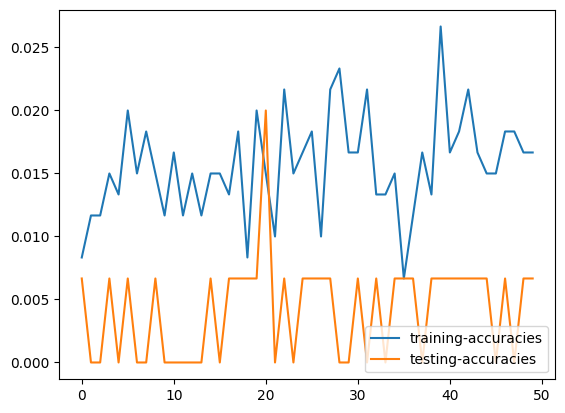

In [418]:
plt.plot(LSTM_model_history.history['accuracy'] , label = 'training-accuracies')
plt.plot(LSTM_model_history.history['val_accuracy'] , label ='testing-accuracies')
plt.legend(loc = 'lower right')

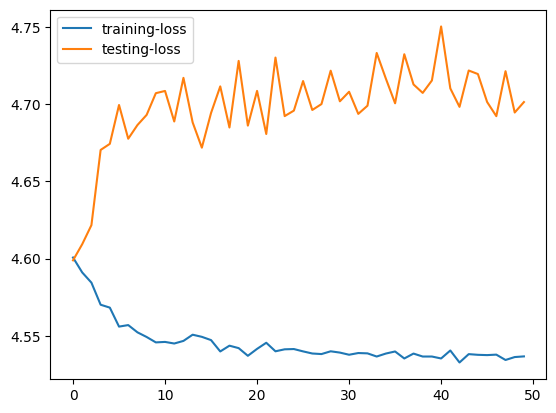

In [419]:
plt.plot(LSTM_model_history.history['loss'] , label = 'training-loss')
plt.plot(LSTM_model_history.history['val_loss'] , label ='testing-loss')
plt.legend(loc = 'upper left')